In [1]:
import mujoco
import mediapy as media
from dm_control import mjcf
import numpy as np
from robot_descriptions.panda_mj_description import MJCF_PATH
from scripts.utils import update_actuator, ActuatorMotor

# np.random.seed(0)

In [2]:
MJCF_PATH = MJCF_PATH[: -len("panda.xml")] + "panda_nohand.xml"

MJCF_PATH

'/home/leo/.cache/robot_descriptions/mujoco_menagerie/franka_emika_panda/panda_nohand.xml'

In [3]:
# load the model
mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# append the body to the end-effector
ee_body = mjcf_model.find("body", "link7")

ee_body

MJCF Element: <body name="link7" pos="0.087999999999999995 0 0" quat="1 1 0 0">...</body>

In [4]:
# old model
old_mjcf_model = mjcf.from_path(MJCF_PATH, escape_separators=True)
# disable collisions for all the geoms
for geom in old_mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

old_model = mjcf.Physics.from_mjcf_model(old_mjcf_model).model._model
old_data = mujoco.MjData(old_model)
body_offset = np.where(old_model.body_dofadr == 0)[0][0]

# create new body
rc = np.array([0.1, 0.05, -0.1])
load_mass = ee_body.add("body", name="load_mass", pos=f"{rc[0]} {rc[1]} {rc[2]}")
load_mass.add(
    "geom", name="load_mass_geom", type="sphere", size="0.05", rgba="0.8 0.2 0.2 1"
)

M = 2.0
# R = 0.0001
I = 1e-3  # M * rc[0]**2

load_mass.add(
    "inertial", mass=f"{M}", pos=f"0 0 0", diaginertia=f"{1e-3} {1e-3} {1e-3}"
)

# disable collision for all the geoms
for geom in mjcf_model.find_all("geom"):
    geom.conaffinity = 0
    geom.contype = 0

physics = mjcf.Physics.from_mjcf_model(mjcf_model)
sim_model = physics.model._model
sim_data = mujoco.MjData(sim_model)
renderer = mujoco.Renderer(sim_model, height=480, width=640)

""

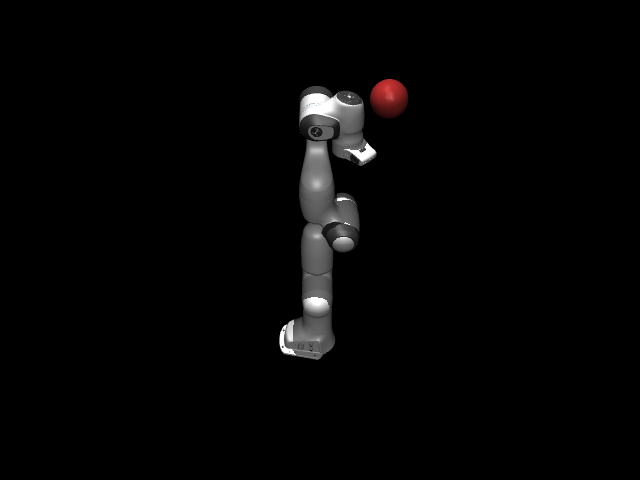

In [5]:
# Reset data, set initial pose.
mujoco.mj_resetData(sim_model, sim_data)

# Step the simulation.
mujoco.mj_step(sim_model, sim_data)

renderer.update_scene(sim_data)
media.show_image(renderer.render())

In [6]:
def staticload_joint_regressor(
    mj_model, mj_data, ee_id, active_joints=7, body_offset=0
):
    accel = np.zeros(6)

    mujoco.mj_rnePostConstraint(mj_model, mj_data)
    mujoco.mj_objectAcceleration(mj_model, mj_data, 2, ee_id, accel, 1)
    rotation = mj_data.xmat[ee_id + body_offset].reshape(3, 3).copy()

    a1, a2, a3 = rotation.T @ np.array([0, 0, 9.81])  #

    static_load_regressor = np.array(
        [
            [a1, 0, 0, 0],
            [a2, 0, 0, 0],
            [a3, 0, 0, 0],
            [0, 0, a3, -a2],
            [0, -a3, 0, a1],
            [0, a2, -a1, 0],
        ]
    )

    jac_lin = np.zeros((3, mj_model.nv))
    jac_rot = np.zeros((3, mj_model.nv))
    mujoco.mj_jacBody(mj_model, mj_data, jac_lin, jac_rot, ee_id + body_offset)
    ee_local_jacobian = np.vstack(
        (
            rotation.T @ jac_lin[:, :active_joints],
            rotation.T @ jac_rot[:, :active_joints],
        )
    )
    joint_regressor = ee_local_jacobian.T @ static_load_regressor

    return joint_regressor

In [7]:
for actuator_id in range(sim_model.nu):
    actuator = ActuatorMotor()
    update_actuator(sim_model, actuator_id, actuator)

# find limits except the last two fingers
lower, upper = np.zeros(sim_model.nq), np.zeros(sim_model.nq)
for jnt_idx in range(sim_model.nq):
    lower[jnt_idx] = sim_model.joint(jnt_idx).range[0]
    upper[jnt_idx] = sim_model.joint(jnt_idx).range[1]

kp = 50
kd = 10
target_q = np.random.uniform(lower, upper)

frames = []
framerate = 25

phase_time = 5.0
num_of_phases = 30
phases = 0
old_data.time = 0
sim_data.time = 0

# print(sim_model.nq)
load_joint_regressor = np.zeros(((sim_model.nq) * num_of_phases, 4))
load_joint_force = np.zeros((sim_model.nq) * num_of_phases)
active_joints = sim_model.nq

while sim_data.time < num_of_phases * phase_time:
    # PD controller
    mujoco.mj_step(sim_model, sim_data)

    target_acc = kp * (target_q - sim_data.qpos) + kd * (
        np.zeros(sim_model.nv) - sim_data.qvel
    )

    # use old data to solve inverse dynamics
    old_data.qpos = sim_data.qpos.copy()
    old_data.qvel = sim_data.qvel.copy()
    old_data.qacc = target_acc
    mujoco.mj_inverse(old_model, old_data)
    sol = old_data.qfrc_inverse

    sim_data.ctrl = sol

    if (
        sim_data.time > phase_time * phases
        and sim_data.time < num_of_phases * phase_time
    ):
        # print(load_force)
        regressor = staticload_joint_regressor(
            old_model, old_data, old_data.body(ee_body.name).id
        ).copy()
        load_joint_regressor[7 * phases : 7 * (phases + 1), :] = regressor

        load_qforce = sol[:7] - old_data.qfrc_bias[:7]
        load_joint_force[7 * phases : 7 * (phases + 1)] = load_qforce.copy()
        actual_load_qforce = regressor @ np.array([M, *(M * rc)])

        # print(load_qforce)
        # print(actual_load_qforce)
        # print()

        phases += 1
        target_q = np.random.uniform(lower, upper)


#     if len(frames) < sim_data.time * framerate:
#         renderer.update_scene(sim_data)
#         frames.append(renderer.render())


# media.show_video(frames, fps=framerate)

In [8]:
M, rc

(2.0, array([ 0.1 ,  0.05, -0.1 ]))

In [9]:
params_estimates = np.linalg.pinv(load_joint_regressor[7:, :]) @ load_joint_force[7:]
mass = params_estimates[0]
coordinate = params_estimates[1:] / mass
mass, coordinate

(1.9976023172657875, array([ 0.09827258,  0.04986133, -0.09827478]))

In [10]:
# check the residual

residual = load_joint_force[7:] - load_joint_regressor[7:, :] @ params_estimates
np.linalg.norm(residual)

1.718152100522178

In [11]:
import mujoco.minimize as minimize

result = minimize.least_squares(
    np.ones(4),
    lambda x: (load_joint_regressor[7:] @ x - load_joint_force[7:]) ** 2,
)
estimates = result[0]
mass = estimates[0]
coordinate = estimates[1:] / mass
mass, coordinate

iter: 0    y: 5.552e+05  log10mu: -inf  ratio: 0.94     dx: 0.99     reduction: 5.2e+05
iter: 1    y: 3.478e+04  log10mu: -inf  ratio: 0.94     dx: 0.49     reduction: 3.3e+04
iter: 2    y: 2192       log10mu: -inf  ratio: 0.94     dx: 0.25     reduction: 2.1e+03
iter: 3    y: 141.6      log10mu: -inf  ratio: 0.94     dx: 0.13     reduction: 1.3e+02
iter: 4    y: 10.34      log10mu: -inf  ratio: 0.95     dx: 0.065    reduction: 8.9    
iter: 5    y: 1.419      log10mu: -inf  ratio: 0.93     dx: 0.041    reduction: 0.8    
iter: 6    y: 0.6162     log10mu: -inf  ratio: 0.75     dx: 0.016    reduction: 0.037  
iter: 7    y: 0.5795     log10mu: -inf  ratio: 0.52     dx: 0.0039   reduction: 0.0011 
iter: 8    y: 0.5784     log10mu: -inf  ratio: 0.5      dx: 0.0019   reduction: 0.00024
iter: 9    y: 0.5782     log10mu: -inf  ratio: 0.5      dx: 0.00093  reduction: 6e-05  
iter: 10   y: 0.5781     log10mu: -inf  ratio: 0.5      dx: 0.00047  reduction: 1.5e-05
iter: 11   y: 0.5781     log10mu

(1.9871651668369628, array([ 0.08775949,  0.05180649, -0.08918887]))

In [12]:
for i in range(len(target_q)):
    print(f"joint {i} target: {target_q[i]:.2f} actual: {sim_data.qpos[i]:.2f}")

joint 0 target: -2.17 actual: -2.13
joint 1 target: -0.95 actual: -0.98
joint 2 target: -2.68 actual: -2.80
joint 3 target: -1.07 actual: -1.22
joint 4 target: 0.44 actual: 0.38
joint 5 target: 0.50 actual: 0.41
joint 6 target: -0.46 actual: -0.30
